In [21]:
## imports
import numpy as np
from sklearn.datasets import load_sample_image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib as mpl
from functools import partial
import tensorflow_datasets as tfds

def crop(images):
    return images[150:220, 130:250]

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [2]:
## dataset

# Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape


# Camadas Convolucionais
- Padding: same ou valid. O padding same preserva a dimensão da imagem, preenchendo com zeros, e o valid reduz, fazendo apenas movimentos válidos.
- Stride: deslocamento vertical e horizontal, geralmente é igual a 1. Quanto maior o stride, mais a dimensão da imagem é reduzida.

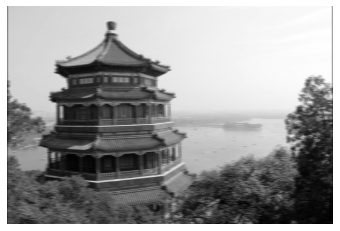

In [11]:
## Implementação com TensorFlow

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) ## altura, largura, número de canais e número de filtros
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

# Camada Pooling
- Geralmente um pixel apenas da vizinhança carrega mais informação que os demais
- Além de reduzir a dimensão da imagem, a vantagem dessa camada está em introduzir invariância a pequenas translações.

## Maxpooling

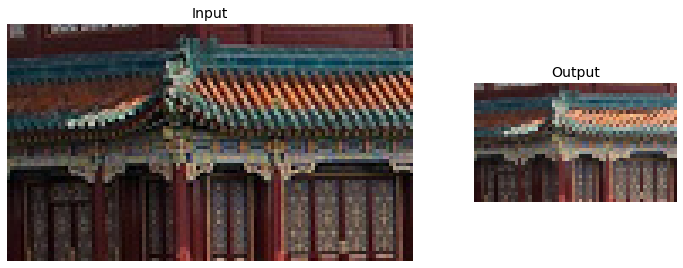

In [9]:
## Maxpooling
max_pool = keras.layers.MaxPool2D(pool_size=2) ## stride = pool_size e padding = valid

cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

## Plota
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Pooling Profundo

In [10]:
## Operando
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
    ## ksize -> tamanho no batch, altura, largura e profundidade.
    ## strides -> stride no batch, altura, largura e profundidade

with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
print(cropped_images.shape)
print(depth_output.shape)

(2, 70, 120, 3)
(2, 70, 120, 1)


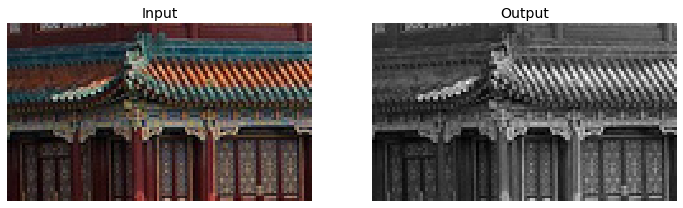

In [18]:
## Plotando
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Pooling Médio

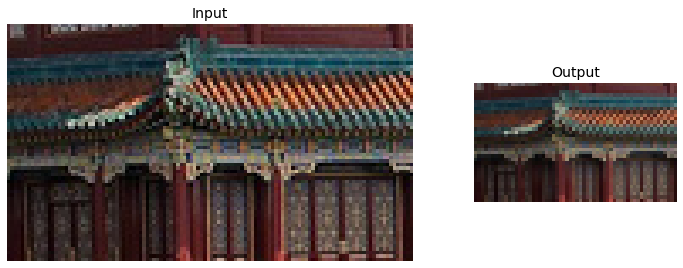

In [19]:
## Average pooling
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Poling Médio Global

In [20]:
## Operando
global_avg_pool = keras.layers.GlobalAvgPool2D()
print(cropped_images.shape)
print(global_avg_pool(cropped_images))

## Equivale a
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

(2, 70, 120, 3)
tf.Tensor(
[[0.2788801  0.22507527 0.20967631]
 [0.51287866 0.4595188  0.3342377 ]], shape=(2, 3), dtype=float32)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

# Arquiteturas Convolucionais
- A primeira camada pode ter um kernel maior e até stride maior, mas para as demais isso não é útil.
- Vai se alternando camadas convolucionais e maxpooling: aumenta-se a profundidade e se diminui a largura.
- Depois disso há camadas fully-connected com dropout.

In [22]:
## Uma Arquitetura Padrão
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 292s 169ms/step - loss: 0.6979 - accuracy: 0.7598 - val_loss: 0.3794 - val_accuracy: 0.8628
Epoch 2/10
1719/1719 [==============================] - 295s 172ms/step - loss: 0.4167 - accuracy: 0.8619 - val_loss: 0.3243 - val_accuracy: 0.8782
Epoch 3/10
1719/1719 [==============================] - 286s 166ms/step - loss: 0.3606 - accuracy: 0.8780 - val_loss: 0.2936 - val_accuracy: 0.8914
Epoch 4/10
1719/1719 [==============================] - 288s 168ms/step - loss: 0.3243 - accuracy: 0.8898 - val_loss: 0.3029 - val_accuracy: 0.8908
Epoch 5/10
1719/1719 [==============================] - 286s 166ms/step - loss: 0.3057 - accuracy: 0.8960 - val_loss: 0.2970 - val_accuracy: 0.8988
Epoch 6/10
1719/1719 [==============================] - 286s 167ms/step - loss: 0.2886 - accuracy: 0.9029 - val_loss: 0.2960 - val_accuracy: 0.8986
Epoch 7/10
1719/1719 [==============================] - 283s 164ms/step - loss: 0.2724 - accuracy: 0.9064 - val_

## Histórico
- <strong>LeNet-5: </strong>Pioneira, mas nenhuma ideia tão interessante.
- <strong>AlexNet: </strong>Usou aumento de dados (regularização) e forçou a ativação de um neurônio inibir neurônios próximos, a fim de que cada neurônio pudesse se especializar em um padrão.
- <strong>GoogLeNet: </strong>Módulos Inception foi a grande novidade, um módulo que aprende vários padrões, concatenando-os. Utilizou muitas camadas convolucionais com kernel 1x1.
- <strong>ResNet: </strong>Conexões com atalhos: facilita o aprendizado, pois já oferece a identidade e também porque permite que haja atalhos para a retropropagação.
- <strong>Xception: </strong>Variante da GoogLeNet: separou completamente a detecção dos padrões espaciais dos padrões entre os canais. Essa arquitetura trocou os módulos inception, que separam um pouco os padrões espaciais dos espaciais, por filtros rasos, que detectam apenas padrões espaciais, concatenados com filtros 1x1 profundos, que detectam apenas padrões entre os canais.
- <strong>SENet: </strong>Impulsionou as arquiteturas anteriores através de uma pequena rede neural chamada bloco SE adicionado à cada unidade da arquitetura anterior (módulo inception ou unidade residual). Esse bloco olha exclusivamente para padrões de profundidade, observando quais padrões costumam ocorrer juntos e fortalecendo esses padrões conjuntamente através de multiplicação (autoencoder seguido de ativação sigmoidal).

## Implementação da ResNet-34

In [8]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding='SAME', use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [9]:
## Construção do Modelo
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='SAME'))
prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_3 (ResidualUni (None, 56, 56, 64)       

# Transfer Learning

## Utilizando um Modelo Pronto Diretamente

In [16]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 9s 0us/step


### Pré-Processando as imagens

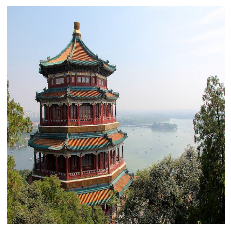

In [10]:
## Primeira opção: não ficou bom, imagem esticada
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


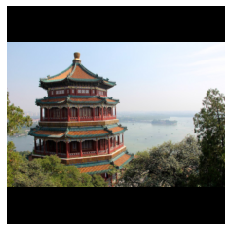

In [11]:
## Segunda opção: padding
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

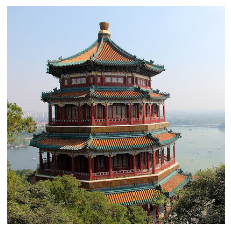

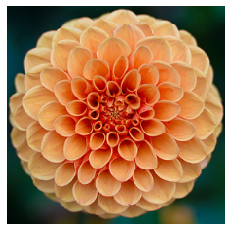

In [17]:
## Terceira opção: cortar a imagem
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

### Utilizando o Modelo

In [18]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255) # pressupõe pixels entre 0 e 255
Y_proba = model.predict(inputs)
print(Y_proba.shape)

top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

(2, 1000)
40960/35363 [==================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



## Treinando a Partir de um Modelo Pronto

### Explorando o Dataset

In [22]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dataset tf_flowers downloaded and prepared to C:\Users\Romano\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [24]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [28]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [30]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [31]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

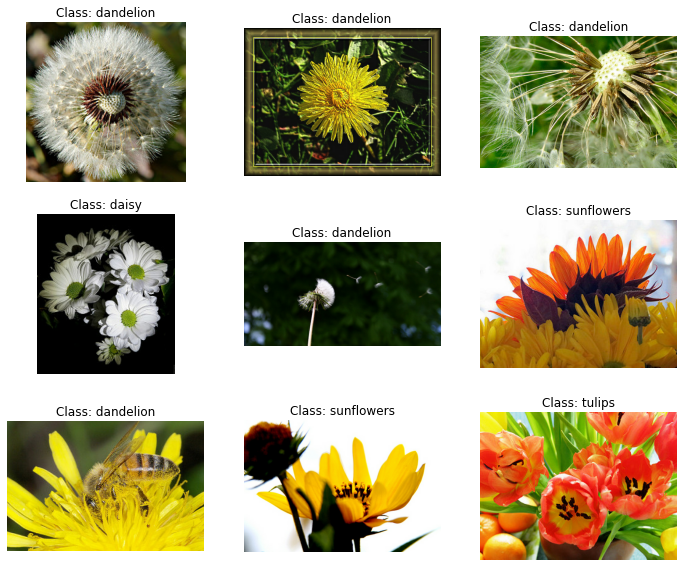

In [32]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

### Pré-Processamento

In [33]:
## Básico
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [34]:
## Sofisticado
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

### Modelo

In [48]:
## Declarando
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

83689472/83683744 [==============================] - 7s 0us/step
0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_39
13 block2_pool
14 batch_normalization_39
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_40
23 block3_pool
24 batch_normalization_40
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_41
33 block4_pool
34 batch_normalization_41
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_s

In [ ]:
## Primeiro Treinamento - Apenas as últimas camadas - Executar no Google Colab -> acurácia de 0.8824
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

In [50]:
## Segundo Treinamento - Rede Inteira - Executar no Google Colab -> acurácia de 0.933
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, ## taxa menor para preservar os pesos da rede
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

# Localização, Detecção e Segmentação

## Classificação e Localização de Objetos
- Na saída há duas redes neurais: uma que prevê a classe e outra que prevê a borda.
- A métrica mais recomendada para a caixa de contorno é a intersecção sobre a união: <span style='font-family: monospace;'>tf.keras.metrics.MeanIoU</span>

In [51]:
## Exemplo de Código
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

## Detecção de Múltiplos Objetos

### Primeira Abordagem: Repetir o Algoritmo Anterior Múltiplas Vezes
- Uma primeira abordagem seria usar caixas de diferentes tamanhos e varrer a imagem diversas vezes.
- Assim, se preservaria apenas a que tivesse maior ativação (acima de um determinado limiar) e seriam descartadas as que tivessem intersecção sobre a união maior que 60%.
- O problema é que seria necessário rodar a rede convolucional diversas vezes, o que seria custoso.

### Você Olha Apenas Uma Vez (YOLO)

#### Abordagem Totalmente Convolucional
- É possível substituir as camadas fully-connected por convolucionais.
- Caso a imagem seja maior, os mapas de características da saída seriam as predições de cada grid da imagem original.
- Assim é possível olhar para imagem apenas uma vez, ao invés de várias, como no algoritmo anterior.

#### YOLO
- Similar à anterior, mas com as seguintes diferenças:
<ul>
    <li>Na saída há 5 caixas de contorno, ao invés de uma, com 5 <span style='font-style:italic'>objectness scores</span>, além das probabilidades das 20 classes.</li>
    <li>Antes de treinar a rede, se encontra 5 dimensões representativas da caixa de contorno através do algoritmo K-Means.</li>
    <li>A rede é treinada para imagens de diferentes escalas.</li>
</ul>
- Se utiliza a métrica Mean Average Precision (mAP): média entre as classes da média da precisão para cada intervalo de 10% de recall.
- Para se aprofundar mais, olhar os papers e também as implementações no github indicadas no livro

## Segmentação de Imagem
- Classificar os pixels de acordo com a classe
- É necessário aumentar a resolução: upsampling, short-cuts e conv2dtranspose.